In [1]:

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import pandas as pd

from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import invwishart
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import seaborn as sns


import random

from models.PriorParameters import GMMPriorParameters
from models.PriorParameters import BMMPriorParameters
from models.GMMGibbs import GMMGibbs
from models.BMMGibbs import BMMGibbs
from models.GMMVBEM import GMMVBEM
from models.BMMVBEM import BMMVBEM
from models.BMMEM import BMMEM
from models.GMMEM import GMMEM

In [2]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [3]:
%%time
params = GMMPriorParameters(X_train, 3)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_train, num_iters=1000, burn=250)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.5670566718445017, 'avg_ll': np.float64(-2.396874498933055), 'avg_pl': np.float64(-323.1403323033912)}
CPU times: user 16 s, sys: 22.6 ms, total: 16 s
Wall time: 16 s


In [3]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [4]:
%%time
params = GMMPriorParameters(X_cover1, 3)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_cover1, num_iters=1000, burn=500)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.5639559276874555, 'avg_ll': np.float64(-2.9856906966963566), 'avg_pl': np.float64(-383.96041358691076)}
CPU times: user 37.7 s, sys: 19.4 ms, total: 37.8 s
Wall time: 37.9 s


In [7]:
X_fitted = gmm_model.posterior_predictive(X_cover1, gmm_model.get_map_params())
print(X_train[0])
print(X_cover1[0])
print(X_fitted[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[-1.7215677 -0.3248398        nan        nan]
[-1.7215677 -0.3248398 -1.330905  -1.1706959]


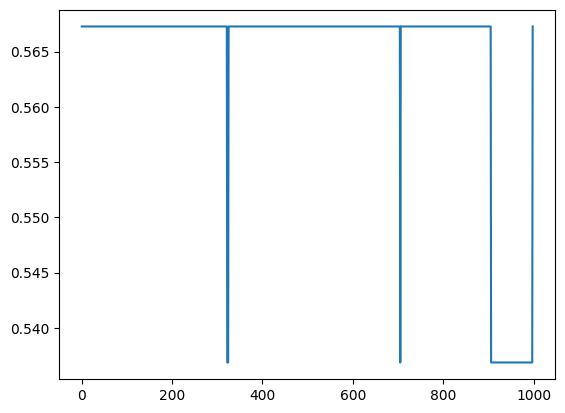

In [11]:
scores = [adjusted_rand_score(s['z'],y_train) for s in samples]
plt.plot(scores)

---

In [6]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

In [7]:
%%time
params = BMMPriorParameters(X_train, 2)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_train, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.6227286656280246, 'avg_ll': np.float64(-46.8256401308499), 'avg_pl': np.float64(-202374.20181412736)}
CPU times: user 7min 11s, sys: 214 ms, total: 7min 11s
Wall time: 1min 27s


---

In [3]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

In [4]:
%%time
params = BMMPriorParameters(X, 13)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y)
print(obj)

{'avg_ari': 0.925169743040436, 'avg_ll': np.float64(-5.781961006432058), 'avg_pl': np.float64(-3626.33537077473)}
CPU times: user 3min 16s, sys: 4.08 s, total: 3min 20s
Wall time: 36.2 s


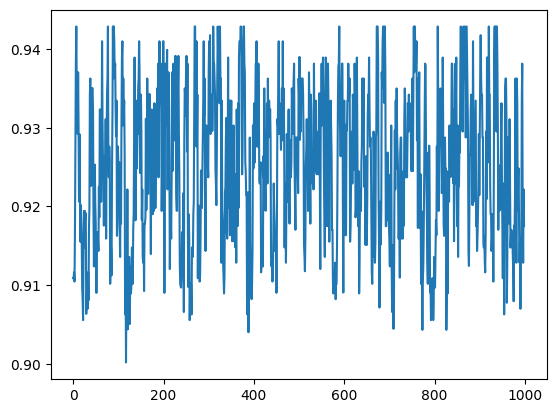

In [5]:
scores = [adjusted_rand_score(sample['z'],y) for sample in samples]
plt.plot(scores)

---
---

# VBEM

In [2]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [3]:
params = GMMPriorParameters(X_train, 3)
gmm_vbem_model = GMMVBEM(params)
result = gmm_vbem_model.fit(X_train, tol=1e-3)
adjusted_rand_score(y_train,result['z'])

0.6834053874293315

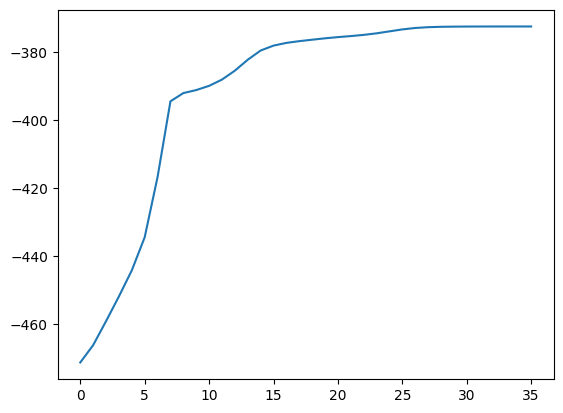

In [7]:
plt.plot(result['elbos'])

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

0.9505736893313538
CPU times: user 1min 24s, sys: 1.36 s, total: 1min 26s
Wall time: 17.8 s


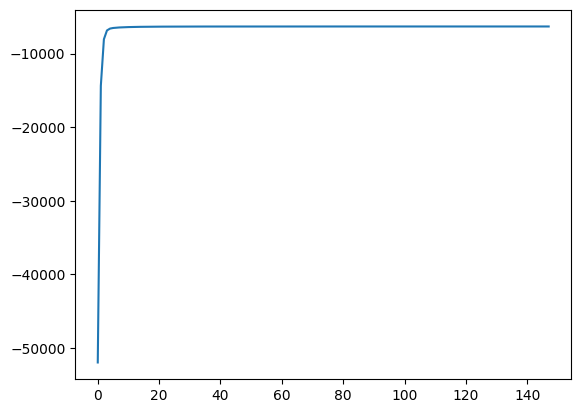

In [3]:
%%time
params = BMMPriorParameters(X, 13)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X, tol=1e-3)
print(adjusted_rand_score(y,result['z']))
plt.plot(result['elbos'])

In [4]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

0.6359385486587681
CPU times: user 4.9 s, sys: 93.2 ms, total: 5 s
Wall time: 999 ms


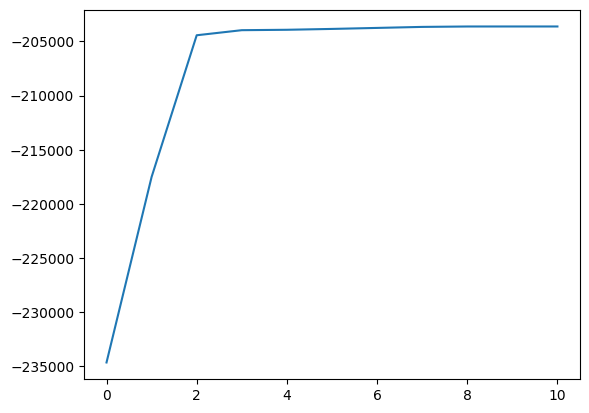

In [6]:
%%time
params = BMMPriorParameters(X_train, 2)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X_train, tol=1e-3)
print(adjusted_rand_score(y_train,result['z']))
plt.plot(result['elbos'])

---

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [4]:
em_bmm_model = BMMEM(2)
z, pi, theta, ll = em_bmm_model.fit(X_cover1)
print(adjusted_rand_score(z, y_train))

0.5958466451771957


In [2]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [3]:
em_gmm_model = GMMEM(3)
result = em_gmm_model.fit(X_cover1)
print(adjusted_rand_score(result['z'], y_train))

0.5035022251126979


In [7]:
X_filled = em_gmm_model.posterior_predict_impute(X_cover1)
print(X_train[0])
print(X_cover1[0])
print(X_filled[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[       nan -0.3248398        nan -1.3201685]
[-1.4667654 -0.3248398 -1.3426257 -1.3201685]


In [ ]:
em_gmm_model = GMMEM(3)
result = em_gmm_model.fit(X_train)
print(adjusted_rand_score(result['z'], y_train))

0.09535551258584408
